In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from acoustic_BEM.geometry import Body, Field
from acoustic_BEM.mesh import Mesh
from acoustic_BEM.integrators import ElementIntegratorCollocation
from acoustic_BEM.matrix_assembly import CollocationAssembler
from acoustic_BEM.solve import BEMSolver

%load_ext autoreload
%autoreload 2

In [2]:
def icosahedron():
    t = (1.0 + np.sqrt(5.0)) / 2.0
    V = np.array([
        [-1,  t, 0],
        [ 1,  t, 0],
        [-1, -t, 0],
        [ 1, -t, 0],
        [ 0, -1,  t],
        [ 0,  1,  t],
        [ 0, -1, -t],
        [ 0,  1, -t],
        [ t,  0, -1],
        [ t,  0,  1],
        [-t,  0, -1],
        [-t,  0,  1],
    ], dtype=float)
    V /= np.linalg.norm(V, axis=1)[:, None]
    F = np.array([
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7,10], [0,10,11],
        [1, 5, 9], [5,11, 4], [11,10,2], [10,7,6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4,11], [6, 2,10], [8, 6, 7], [9, 8, 1]
    ], dtype=int)
    return V, F

def subdivide_sphere(V, F, levels=1):
    """Loop-subdivide each triangle and re-project to unit sphere."""
    for _ in range(levels):
        mid_cache = {}
        newF = []
        def midpoint(i, j):
            key = tuple(sorted((i, j)))
            if key in mid_cache: return mid_cache[key]
            m = (V[i] + V[j]) * 0.5
            m = m / np.linalg.norm(m)
            idx = len(V_list)
            V_list.append(m)
            mid_cache[key] = idx
            return idx
        V_list = [v.copy() for v in V]
        for a,b,c in F:
            ab = midpoint(a,b)
            bc = midpoint(b,c)
            ca = midpoint(c,a)
            newF += [
                [a, ab, ca],
                [b, bc, ab],
                [c, ca, bc],
                [ab, bc, ca],
            ]
        V = np.asarray(V_list)
        F = np.asarray(newF, dtype=int)
    return V, F

### Uncomment to visualize the mesh
a = 0.075              # sphere radius [m]
subdiv = 2
V, F = icosahedron()
V, F = subdivide_sphere(V, F, levels=subdiv)
V = a * V

pl = pv.Plotter()
pv_mesh = pv.PolyData(V, np.hstack([np.full((F.shape[0],1),3), F]))
pl.add_mesh(pv_mesh, show_edges=True)
pl.show()

Widget(value='<iframe src="http://localhost:50429/index.html?ui=P_0x19881088ef0_0&reconnect=auto" class="pyvis…

In [3]:
def analytic_phi_pulsating_sphere(r: np.ndarray, 
                                  a: float, 
                                  k: float, 
                                  vr: complex) -> np.ndarray:
    
    A = a/r * 1.225 * 343 * vr * (1j * k * a) / (1-1j*k*a)
    return A * np.exp(1j*k*(r - a))

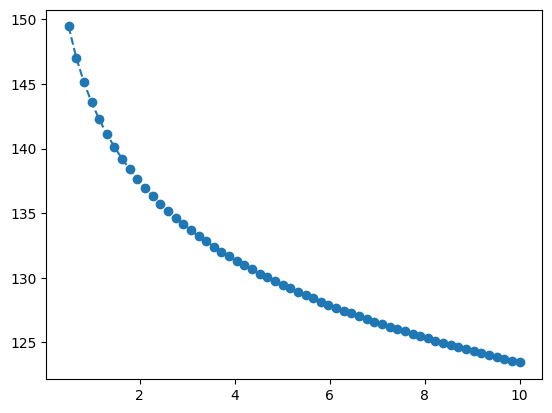

In [54]:
frequency = 54.59                         # frequency [Hz]
c0 = 343                               # speed of sound [m/s]
omega = 2 * np.pi * frequency          # angular frequency [rad/s]
k = omega / c0                         # wavenumber [rad/m]
rho0 = 1.225                           # density of air [kg/m^3]

radius = 1                         # radius of pulsating sphere [m]
Vr = 1                          # normal velocity on sphere surface [m/s]

plane_extent = 10
rs = np.linspace(0.5, plane_extent, 60)
p_ref = analytic_phi_pulsating_sphere(rs, radius, k, Vr)

plt.plot(rs/radius, 20 * np.log10(np.abs(p_ref)/(2 * 10**-5)), label='Analytic', marker='o', linestyle='--')

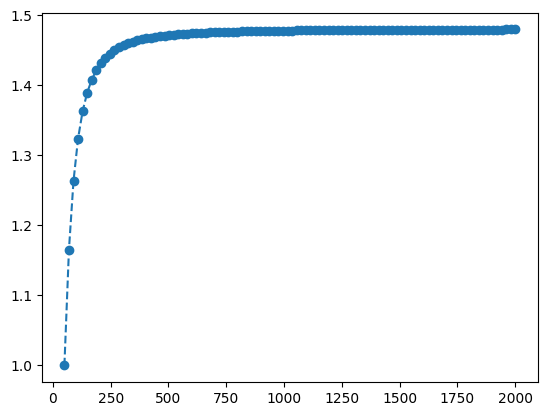

In [63]:
frequency = np.linspace(50, 2000, 100)  # frequency [Hz]
c0 = 343                               # speed of sound [m/s]
omega = 2 * np.pi * frequency          # angular frequency [rad/s]
k = omega / c0                         # wavenumber [rad/m]
rho0 = 1.225                           # density of air [kg/m^3]

radius = 1                         # radius of pulsating sphere [m]
Vr = 1                          # normal velocity on sphere surface [m/s]

plane_extent = 10
rs = 2
p_ref = analytic_phi_pulsating_sphere(rs, radius, k, Vr)

plt.plot(frequency, np.abs(p_ref)/np.abs(p_ref[0]), label='Analytic', marker='o', linestyle='--')

In [72]:
subdiv = 2                             # mesh subdivision level
nodes, elements = icosahedron()
nodes, elements = subdivide_sphere(nodes, elements, levels=subdiv)
nodes *= radius

vel_BC = np.ones(nodes.shape[0]) * Vr

field_pts_safe = np.array([0, 0, 1])[:, None] * np.linspace(2.0, 2.1, 1)
field_pts_safe = field_pts_safe.T
field_pts_safe.shape

# print(f'Mesh has {nodes.shape[0]} vertices and {elements.shape[0]} faces.')
# print(f'Characteristic length: {char_length:.2f} m')
# print(f'Wavenumber: {k:.2f} 1/m')
# print(f'k*L = {k*char_length:.2f}')
# print(f'Wavelength: {2*np.pi/k:.2f} m')
# print(f'Velocity BC: {np.min(np.abs(vel_BC)):.4f} to {np.max(np.abs(vel_BC)):.4f} m/s')

(1, 3)

In [65]:
# Init package objects
p_bem = []
for f_i in tqdm(np.linspace(50, 2000, 100)):

    sphere = Body(mesh_nodes=nodes, 
              mesh_elements=elements, 
              Neumann_BC=vel_BC,
              Dirichlet_BC=None,
              frequency=f_i)
    
    field = Field(field_extent=np.array([[3, 3.5],
                [0, 0.5],
                [0, 0.5]]),
                num_points=np.array([1, 1, 1]),
                rho0=rho0,
                c0=c0,)

    mesh = Mesh(source_object=sphere,
                peripheral_objects=None,
                field=field)

    integrator = ElementIntegratorCollocation(k = mesh.k,
                                            kernel_mode = "free")
    assembler = CollocationAssembler(mesh, integrator, quad_order=7)
    solver = BEMSolver(assembler=assembler)

    mats = {
        "S": assembler.assemble("S", verbose=False),
        "D": assembler.assemble("D", verbose=False),
    }

    # mats_bm = {
    #     "S": assembler.assemble("S", verbose=False),
    #     "D": assembler.assemble("D", verbose=False),
    #     "Kp": assembler.assemble("Kp", verbose=False),
    #     "N": assembler.assemble("NReg", verbose=False),
    # }

    phi_bnd = solver.solve_direct(matrices=mats)
    # phi_bnd = solver.solve_burton_miller(matrices=mats_bm,
    #                                  alpha = -1j/mesh.k)
    
    omega = 2 * np.pi * f_i
    
    phi_field = solver.evaluate_field(field_pts_safe, quad_order=7, verbose=False)
    p_field = 1j * omega * rho0 * phi_field
    p_bem.append(p_field)

  0%|          | 0/100 [00:00<?, ?it/s]

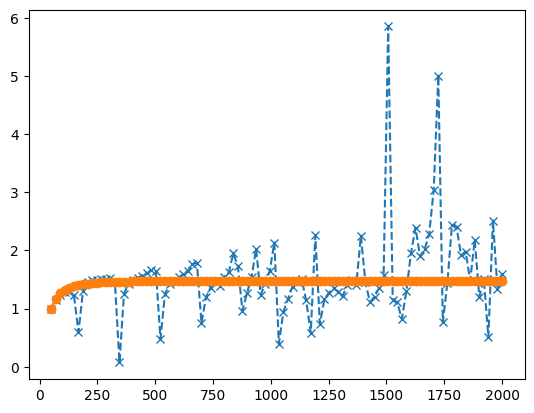

In [67]:
plt.plot(np.linspace(50, 2000, 100), np.abs(p_bem)/np.abs(p_bem[0]), label='BEM', marker='x', linestyle='--')
plt.plot(frequency, np.abs(p_ref)/np.abs(p_ref[0]), label='Analytic', marker='o', linestyle='--')

In [77]:
p_bem_bm = []
for f_i in tqdm(np.linspace(50, 2000, 100)):

    sphere = Body(mesh_nodes=nodes, 
              mesh_elements=elements, 
              Neumann_BC=vel_BC,
              Dirichlet_BC=None,
              frequency=f_i)
    
    field = Field(field_extent=np.array([[3, 3.5],
                [0, 0.5],
                [0, 0.5]]),
                num_points=np.array([1, 1, 1]),
                rho0=rho0,
                c0=c0,)

    mesh = Mesh(source_object=sphere,
                peripheral_objects=None,
                field=field)

    integrator = ElementIntegratorCollocation(k = mesh.k,
                                            kernel_mode = "free")
    assembler = CollocationAssembler(mesh, integrator, quad_order=7)
    solver = BEMSolver(assembler=assembler)

    mats_bm = {
        "S": assembler.assemble("S", verbose=False),
        "D": assembler.assemble("D", verbose=False),
        "Kp": assembler.assemble("Kp", verbose=False),
        "N": assembler.assemble("N", verbose=False),
    }

    phi_bnd = solver.solve_burton_miller(matrices=mats_bm,
                                         alpha= -1.0/mesh.k)
    
    omega = 2 * np.pi * f_i
    
    phi_field = solver.evaluate_field(field_pts_safe, quad_order=7, verbose=False)
    p_field = 1j * omega * rho0 * phi_field
    p_bem_bm.append(p_field)

  0%|          | 0/100 [00:00<?, ?it/s]

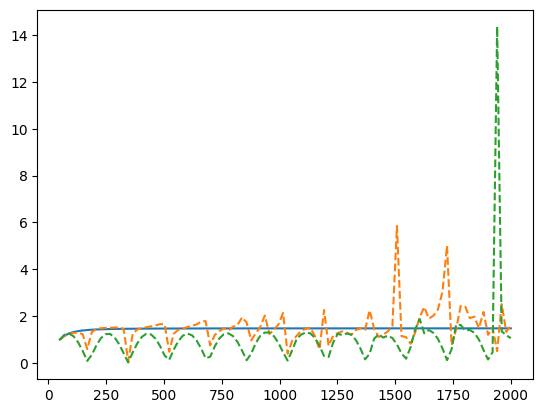

In [78]:
plt.plot(frequency, np.abs(p_ref)/np.abs(p_ref[0]), label='Analytic')
plt.plot(np.linspace(50, 2000, 100), np.abs(p_bem)/np.abs(p_bem[0]), label='BEM', linestyle='--')
plt.plot(np.linspace(50, 2000, 100), np.abs(p_bem_bm)/np.abs(p_bem_bm[0]), label='BEM BM', linestyle='--')

In [79]:
for f_i in tqdm(np.linspace(50, 2000, 100)):

    sphere = Body(mesh_nodes=nodes, 
              mesh_elements=elements, 
              Neumann_BC=vel_BC,
              Dirichlet_BC=None,
              frequency=f_i)
    
    field = Field(field_extent=np.array([[3, 3.5],
                [0, 0.5],
                [0, 0.5]]),
                num_points=np.array([1, 1, 1]),
                rho0=rho0,
                c0=c0,)

    mesh = Mesh(source_object=sphere,
                peripheral_objects=None,
                field=field)

    integrator = ElementIntegratorCollocation(k = mesh.k,
                                            kernel_mode = "free")
    assembler = CollocationAssembler(mesh, integrator, quad_order=7)
    solver = BEMSolver(assembler=assembler)

    # Direct
    mats_direct = {
        "S": assembler.assemble("S", verbose=False),
        "D": assembler.assemble("D", verbose=False),
    }
    phi_direct = solver.solve_direct(matrices=mats_direct)

    # Burton–Miller
    mats_bm = {
        "S": mats_direct["S"],
        "D": mats_direct["D"],
        "Kp": assembler.assemble("Kp", verbose=False),
        "N": assembler.assemble("N", verbose=False),  # or "NReg"
    }
    phi_bm = solver.solve_burton_miller(matrices=mats_bm)  # alpha=None

    rel_err = np.linalg.norm(phi_bm - phi_direct) / np.linalg.norm(phi_direct)
    print(f"f = {f_i:.1f} Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = {rel_err:.3e}")

  0%|          | 0/100 [00:00<?, ?it/s]

f = 50.0 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.028e+00
f = 69.7 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.045e+00
f = 89.4 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.066e+00
f = 109.1 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.083e+00
f = 128.8 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.080e+00
f = 148.5 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.049e+00
f = 168.2 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 9.674e-01
f = 187.9 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 9.634e-01
f = 207.6 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 9.287e-01
f = 227.3 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 9.482e-01
f = 247.0 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.011e+00
f = 266.7 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.086e+00
f = 286.4 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.140e+00
f = 306.1 Hz,  ||phi_BM - phi_direct|| / ||phi_direct|| = 1.144e+00
f = 325.8 Hz,  ||phi_BM - phi_direct|| / ||phi_dire

KeyboardInterrupt: 